# Problem Description

### Predict employee attrition

Predict the Flat Resale Prices in Singapore
Investing in Flats is the biggest investment for most households in cities like Singapore which is very
small but heavily urbanised. Therefore, being able to accurately value the flat prices will not only
facilitate market transactions by providing valuable guidance for all market participants (be it home
owners, home buyers, landlords, tenants or banks that underwrite mortgages), but also provide
useful insights for policy makers and government authorities in understanding the current state of
the economy.

In [59]:
import os

import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [60]:
#!pip install xgboost

In [61]:
def f1_accuracy_precision_recall_metrics(y_true, y_pred): # (y,y^)

    RMSE = mean_squared_error(y_true, y_pred, sample_weight=None, multioutput='uniform_average')    
    print("RMSE            : ",RMSE)


## Reading data

In [62]:
train_1 = pd.read_csv("train1.csv",sep=',', header=0, na_values= ('unknown','<'))
train_2 = pd.read_csv("train2.csv",sep=',', header=0, na_values=('unknown','<'))
train_3 = pd.read_csv("train3.csv",sep=',', header=0, na_values=('unknown','<'))
mith_test_data = pd.read_csv("test.csv",sep=',', header=0, na_values=('unknown','<'))
building_mrt_data = pd.read_csv("building_to_mrt_distance.csv",sep=',', header=0, na_values=('unknown','<'))

In [63]:
print(train_1.shape)
print(train_2.shape)
print(train_3.shape)
print(mith_test_data.shape)
print(building_mrt_data.shape)

(52203, 11)
(37153, 12)
(32578, 12)
(21846, 11)
(8811, 120)


In [64]:
print(train_1.columns,"\n") 
print(train_2.columns,"\n")
print(train_3.columns,"\n")
print(mith_test_data.columns,"\n")
print(building_mrt_data.columns,"\n")

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price',
       'uniqueID'],
      dtype='object') 

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price', 'uniqueID'],
      dtype='object') 

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'resale_price', 'uniqueID'],
      dtype='object') 

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date',
       'remaining_lease', 'uniqueID'],
      dtype='object') 

Index(['Building', 'Jurong East MRT station', 'Bukit Batok MRT station',
       'Bukit Gombak MRT station', 'Choa Chu Kang MRT station',
       'Yew Tee MRT statio

## concatinating the Data

### For train

### Merging train2 and train3 data

In [65]:
print(train_2.shape)
print(train_3.shape)
frames = [train_2, train_3]
train_2_3 = pd.concat(frames)
print(train_2_3.shape)

(37153, 12)
(32578, 12)
(69731, 12)


### merging train1 and train_2_3 data

In [66]:
train_1.head()

month        town flat_type block        street_name storey_range  \
0  2012-03  ANG MO KIO    2 ROOM   172   ANG MO KIO AVE 4     06 TO 10   
1  2012-03  ANG MO KIO    2 ROOM   510   ANG MO KIO AVE 8     01 TO 05   
2  2012-03  ANG MO KIO    3 ROOM   610   ANG MO KIO AVE 4     06 TO 10   
3  2012-03  ANG MO KIO    3 ROOM   474  ANG MO KIO AVE 10     01 TO 05   
4  2012-03  ANG MO KIO    3 ROOM   604   ANG MO KIO AVE 5     06 TO 10   

   floor_area_sqm      flat_model  lease_commence_date  resale_price  uniqueID  
0            45.0        Improved                 1986      250000.0    100000  
1            44.0        Improved                 1980      265000.0    100001  
2            68.0  New Generation                 1980      315000.0    100002  
3            67.0  New Generation                 1984      320000.0    100003  
4            67.0  New Generation                 1980      321000.0    100004

In [67]:
train_2_3.head()

month        town flat_type block        street_name storey_range  \
0  2015-01  ANG MO KIO    3 ROOM   174   ANG MO KIO AVE 4     07 TO 09   
1  2015-01  ANG MO KIO    3 ROOM   541  ANG MO KIO AVE 10     01 TO 03   
2  2015-01  ANG MO KIO    3 ROOM   163   ANG MO KIO AVE 4     01 TO 03   
3  2015-01  ANG MO KIO    3 ROOM   446  ANG MO KIO AVE 10     01 TO 03   
4  2015-01  ANG MO KIO    3 ROOM   557  ANG MO KIO AVE 10     07 TO 09   

   floor_area_sqm      flat_model  lease_commence_date remaining_lease  \
0            60.0        Improved                 1986              70   
1            68.0  New Generation                 1981              65   
2            69.0  New Generation                 1980              64   
3            68.0  New Generation                 1979              63   
4            68.0  New Generation                 1980              64   

   resale_price  uniqueID  
0      255000.0    152203  
1      275000.0    152204  
2      285000.0    152205  
3      290000.0    152206  
4      290000.0    152207

In [68]:
print(train_1.shape)    # in 52,203 rows remaining_lease is missing
print(train_2_3.shape)  

(52203, 11)
(69731, 12)


In [69]:
train_2_3.drop("remaining_lease",axis = 1,inplace = True)

In [70]:
print(train_1.shape)   
print(train_2_3.shape)  

(52203, 11)
(69731, 11)


In [71]:
frames = [train_1, train_2_3]
mith_train_data = pd.concat(frames)
print(mith_train_data.shape)

(121934, 11)


In [72]:
mith_train_data.head()

month        town flat_type block        street_name storey_range  \
0  2012-03  ANG MO KIO    2 ROOM   172   ANG MO KIO AVE 4     06 TO 10   
1  2012-03  ANG MO KIO    2 ROOM   510   ANG MO KIO AVE 8     01 TO 05   
2  2012-03  ANG MO KIO    3 ROOM   610   ANG MO KIO AVE 4     06 TO 10   
3  2012-03  ANG MO KIO    3 ROOM   474  ANG MO KIO AVE 10     01 TO 05   
4  2012-03  ANG MO KIO    3 ROOM   604   ANG MO KIO AVE 5     06 TO 10   

   floor_area_sqm      flat_model  lease_commence_date  resale_price  uniqueID  
0            45.0        Improved                 1986      250000.0    100000  
1            44.0        Improved                 1980      265000.0    100001  
2            68.0  New Generation                 1980      315000.0    100002  
3            67.0  New Generation                 1984      320000.0    100003  
4            67.0  New Generation                 1980      321000.0    100004

In [73]:
mith_train_data.head()

month        town flat_type block        street_name storey_range  \
0  2012-03  ANG MO KIO    2 ROOM   172   ANG MO KIO AVE 4     06 TO 10   
1  2012-03  ANG MO KIO    2 ROOM   510   ANG MO KIO AVE 8     01 TO 05   
2  2012-03  ANG MO KIO    3 ROOM   610   ANG MO KIO AVE 4     06 TO 10   
3  2012-03  ANG MO KIO    3 ROOM   474  ANG MO KIO AVE 10     01 TO 05   
4  2012-03  ANG MO KIO    3 ROOM   604   ANG MO KIO AVE 5     06 TO 10   

   floor_area_sqm      flat_model  lease_commence_date  resale_price  uniqueID  
0            45.0        Improved                 1986      250000.0    100000  
1            44.0        Improved                 1980      265000.0    100001  
2            68.0  New Generation                 1980      315000.0    100002  
3            67.0  New Generation                 1984      320000.0    100003  
4            67.0  New Generation                 1980      321000.0    100004

### For test

In [74]:
mith_test_data.shape

(21846, 11)

In [75]:
mith_test_data.drop("remaining_lease",axis = 1,inplace = True)

In [76]:
mith_test_data.shape

(21846, 10)

In [77]:
mith_test_data.head()

month        town flat_type block        street_name storey_range  \
0  2018-08  ANG MO KIO    2 ROOM   323   ANG MO KIO AVE 3     01 TO 03   
1  2018-08  ANG MO KIO    3 ROOM   220   ANG MO KIO AVE 1     07 TO 09   
2  2018-08  ANG MO KIO    3 ROOM   220   ANG MO KIO AVE 1     07 TO 09   
3  2018-08  ANG MO KIO    3 ROOM   445  ANG MO KIO AVE 10     01 TO 03   
4  2018-08  ANG MO KIO    3 ROOM   471  ANG MO KIO AVE 10     01 TO 03   

   floor_area_sqm      flat_model  lease_commence_date  uniqueID  
0            44.0        Improved                 1977    221934  
1            82.0  New Generation                 1977    221935  
2            67.0  New Generation                 1977    221936  
3            67.0  New Generation                 1979    221937  
4            67.0  New Generation                 1979    221938

## Understanding the data

### For Train

In [78]:
mith_train_data.shape

(121934, 11)

In [79]:
mith_train_data.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price',
       'uniqueID'],
      dtype='object')

In [80]:
mith_train_data.dtypes

month                   object
town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
resale_price           float64
uniqueID                 int64
dtype: object

In [81]:
mith_train_data.describe()

floor_area_sqm  lease_commence_date  resale_price       uniqueID
count   121934.000000        121934.000000  1.219340e+05  121934.000000
mean        96.998518          1990.887538  4.494886e+05  160966.500000
std         24.559239            10.963790  1.357230e+05   35199.458199
min         31.000000          1966.000000  1.700000e+05  100000.000000
25%         74.000000          1984.000000  3.500000e+05  130483.250000
50%         96.000000          1989.000000  4.230000e+05  160966.500000
75%        112.000000          2000.000000  5.150000e+05  191449.750000
max        280.000000          2016.000000  1.180000e+06  221933.000000

In [82]:
mith_train_data.describe(include = 'object')

month         town flat_type   block     street_name storey_range  \
count    121934       121934    121934  121934          121934       121934   
unique       77           26         7    2216             527           25   
top     2018-07  JURONG WEST    4 ROOM       2  YISHUN RING RD     04 TO 06   
freq       2539         9807     48744     501            2085        27861   

       flat_model  
count      121934  
unique         21  
top       Model A  
freq        35539

In [83]:
mith_train_data.dtypes

month                   object
town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
resale_price           float64
uniqueID                 int64
dtype: object

### For Test

In [84]:
mith_test_data.shape

(21846, 10)

In [85]:
mith_test_data.columns

Index(['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range',
       'floor_area_sqm', 'flat_model', 'lease_commence_date', 'uniqueID'],
      dtype='object')

In [86]:
mith_test_data.dtypes

month                   object
town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
uniqueID                 int64
dtype: object

In [87]:
mith_test_data.describe()

floor_area_sqm  lease_commence_date       uniqueID
count    21846.000000         21846.000000   21846.000000
mean        97.425744          1993.758354  232856.500000
std         24.250775            12.643644    6306.541326
min         31.000000          1966.000000  221934.000000
25%         81.000000          1984.000000  227395.250000
50%         95.000000          1993.000000  232856.500000
75%        112.000000          2003.000000  238317.750000
max        237.000000          2016.000000  243779.000000

In [88]:
mith_test_data.describe(include = 'object')

month       town flat_type  block     street_name storey_range  \
count     21846      21846     21846  21846           21846        21846   
unique       12         26         7   2193             532           17   
top     2019-07  WOODLANDS    4 ROOM      2  YISHUN RING RD     04 TO 06   
freq       2123       1802      9106     83             315         5160   

       flat_model  
count       21846  
unique         19  
top       Model A  
freq         7370

## Data visualisation

### Considering Bar Chart for categorical variables to visualize data

Text(0,0.5,'flat_type')

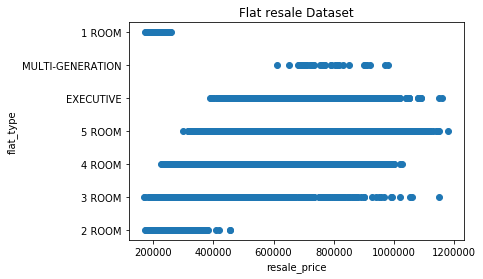

In [89]:
fig, ax = plt.subplots()

# scatter the sepal_length against the sepal_width
ax.scatter(mith_train_data['resale_price'], mith_train_data['flat_type'])
# set a title and labels
ax.set_title('Flat resale Dataset')
ax.set_xlabel('resale_price')
ax.set_ylabel('flat_type')

Text(0,0.5,'storey_range')

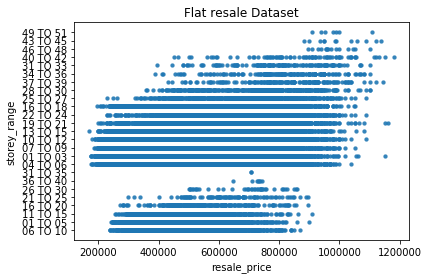

In [90]:
fig, ax = plt.subplots()

# scatter the sepal_length against the sepal_width
ax.scatter(mith_train_data['resale_price'],mith_train_data['storey_range'], s=15, alpha = .9, linewidths= .3, verts=None)
# set a title and labels
ax.set_title('Flat resale Dataset')
ax.set_xlabel('resale_price')
ax.set_ylabel('storey_range')

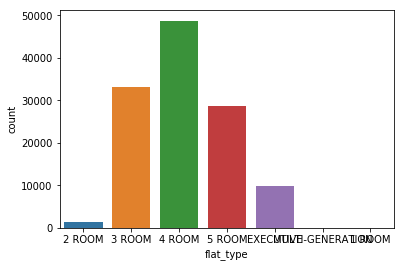

In [91]:
sns.countplot(x='flat_type',data=mith_train_data)
plt.show()

### A heat map is a graphical representation of data where the individual values contained in a matrix are represented as colors.

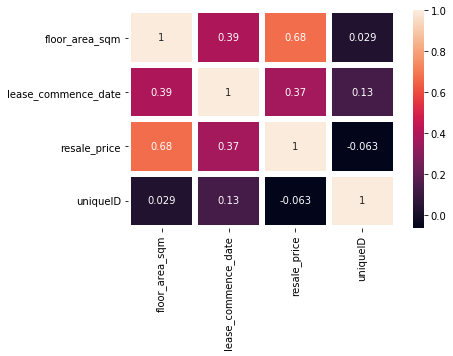

In [92]:
corr = mith_train_data.corr()
ax = sns.heatmap(corr,annot =True, linewidth = 5, cbar = True)

#### Histogram is used below for Discrete continous variables for numerical data

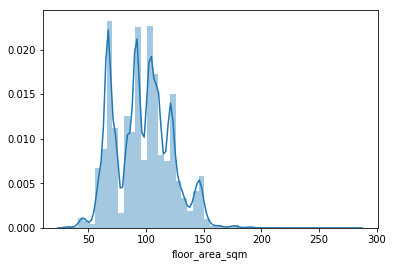

In [94]:
%matplotlib inline
sns.distplot(mith_train_data["floor_area_sqm"])

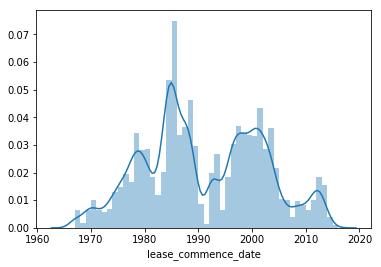

In [95]:
%matplotlib inline
sns.distplot(mith_train_data["lease_commence_date"])

In [96]:
mith_train_data.dtypes

month                   object
town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
resale_price           float64
uniqueID                 int64
dtype: object

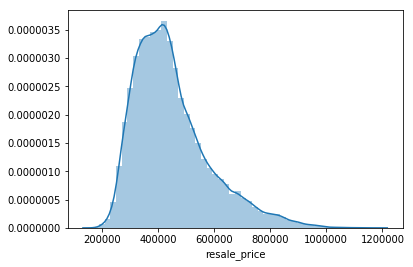

In [97]:
%matplotlib inline
sns.distplot(mith_train_data["resale_price"])

In [98]:
#mith_train_data["resale_price"] = log(mith_train_data["resale_price"])
#mith_train_data.log("resale_price",axis = 1,inplace = True)
#mith_train_data['resale_price'] = mith_train_data['resale_price'].apply(log)
mith_train_data.skew(axis = 1, skipna = True).head()

0    1.201841
1    1.277887
2    1.470780
3    1.485975
4    1.488919
dtype: float64

In [99]:
# mith_train_data.boxplot(by ='Left_Company', column =['TotalWorkingHours'], grid = False, figsize=(15, 10)) 

### _Some Insights from the EDA done above_

* From the correlation plot, it is observed that there is no multicollinearity between any columns. 

* From scatter plot it is observed that the highest resale value is for 5 Bedroom flat rather than Executive/multi-generation

* By visualising the target column(resale price) its observed that the graph is left skewed and can be fixed by log or sqrt same   could be done for floor area.

* storey range from 40-42 has the highest resale value price.

In [100]:
mith_train_data.dtypes

month                   object
town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
resale_price           float64
uniqueID                 int64
dtype: object

### Droping unnecessary variables

In [103]:
mith_train_data.drop("uniqueID",axis = 1,inplace = True)
mith_test_data.drop("uniqueID",axis = 1,inplace = True)
mith_test_data.head()


month        town flat_type block        street_name storey_range  \
0  2018-08  ANG MO KIO    2 ROOM   323   ANG MO KIO AVE 3     01 TO 03   
1  2018-08  ANG MO KIO    3 ROOM   220   ANG MO KIO AVE 1     07 TO 09   
2  2018-08  ANG MO KIO    3 ROOM   220   ANG MO KIO AVE 1     07 TO 09   
3  2018-08  ANG MO KIO    3 ROOM   445  ANG MO KIO AVE 10     01 TO 03   
4  2018-08  ANG MO KIO    3 ROOM   471  ANG MO KIO AVE 10     01 TO 03   

   floor_area_sqm      flat_model  lease_commence_date  
0            44.0        Improved                 1977  
1            82.0  New Generation                 1977  
2            67.0  New Generation                 1977  
3            67.0  New Generation                 1979  
4            67.0  New Generation                 1979

In [104]:
print(mith_train_data.shape)
print(mith_test_data.shape)

(121934, 10)
(21846, 9)


### Type Casting (object to category)

#### _For Train_

In [105]:
print(list(mith_train_data.columns))

['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'floor_area_sqm', 'flat_model', 'lease_commence_date', 'resale_price']


In [106]:
mith_train_data.dtypes

month                   object
town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
resale_price           float64
dtype: object

In [ ]:
for col in ('block', 'flat_model', 'flat_type', 'month',"storey_range","street_name","town"):
    mith_train_data[col] = mith_train_data[col].astype('category')

In [108]:
for col in ('floor_area_sqm', 'resale_price'):
    mith_train_data[col] = mith_train_data[col].astype('int64')

In [109]:
mith_train_data.dtypes

month                  category
town                   category
flat_type              category
block                  category
street_name            category
storey_range           category
floor_area_sqm            int64
flat_model             category
lease_commence_date       int64
resale_price              int64
dtype: object

#### _For Test_

In [110]:
mith_test_data.dtypes

month                   object
town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
dtype: object

In [111]:
mith_test_data['floor_area_sqm'] = mith_test_data['floor_area_sqm'].astype('int64')

In [112]:
mith_test_data.dtypes

month                  object
town                   object
flat_type              object
block                  object
street_name            object
storey_range           object
floor_area_sqm          int64
flat_model             object
lease_commence_date     int64
dtype: object

In [113]:
for col in ('block', 'flat_model', 'flat_type', 'month',"storey_range","street_name","town"):
    mith_test_data[col] = mith_test_data[col].astype('category')

In [114]:
mith_test_data.dtypes

month                  category
town                   category
flat_type              category
block                  category
street_name            category
storey_range           category
floor_area_sqm            int64
flat_model             category
lease_commence_date       int64
dtype: object

### Additonl 

In [115]:
# converting target column from float to int
#mith_train_data.Left_Company = mith_train_data.Left_Company.astype(int)

### Split Numeric and Categorical Columns

In [116]:
#cat_attr = list(mith_train_data.select_dtypes("category").columns)
#num_attr = list(mith_train_data.columns.difference(cat_attr))

cat_attr_train = list(mith_train_data.select_dtypes("category").columns)
num_attr_train = list(mith_train_data.columns.difference(cat_attr_train))

num_attr_train.remove('resale_price')


In [117]:
print(list(cat_attr_train))

['month', 'town', 'flat_type', 'block', 'street_name', 'storey_range', 'flat_model']


In [118]:
print(list(num_attr_train))

['floor_area_sqm', 'lease_commence_date']


### Handling missing values

In [119]:
mith_train_data.isnull().sum()

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
resale_price           0
dtype: int64

In [120]:
mith_test_data.isnull().sum()

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
dtype: int64

In [121]:
# print columns with missing values
missing_cols = mith_train_data.columns[mith_train_data.isnull().any()]
missing_cols

Index([], dtype='object')

## Pipeline

In [122]:
train_num_attr = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])


train_cat_attr = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', train_num_attr, num_attr_train),
        ('cat', train_cat_attr, cat_attr_train)])

## Train validation split

In [123]:
y = mith_train_data["resale_price"]
x = mith_train_data.drop(["resale_price"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 123)

In [124]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(85353, 9)
(85353,)
(36581, 9)
(36581,)


In [110]:
X_train.dtypes

month                  category
town                   category
flat_type              category
block                  category
street_name            category
storey_range           category
floor_area_sqm            int64
flat_model             category
lease_commence_date       int64
dtype: object

In [111]:
y_train.dtypes

dtype('int64')

In [112]:
mith_train_data.dtypes

month                  category
town                   category
flat_type              category
block                  category
street_name            category
storey_range           category
floor_area_sqm            int64
flat_model             category
lease_commence_date       int64
resale_price              int64
dtype: object

## OLS Regression - Model - 1

In [392]:
clf_olsreg = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', LinearRegression())])

In [393]:
%%time
clf_olsreg.fit(X_train, y_train)

Wall time: 21.9 s


Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                             

In [394]:
train_pred = clf_olsreg.predict(X_train)
test_pred = clf_olsreg.predict(X_test)
print(clf_olsreg.score(X_train, y_train))
print(clf_olsreg.score(X_test, y_test))

0.9391380616398539
0.9343954920691615


In [426]:
test_sample_pred = clf_olsreg.predict(mith_test_data)

In [430]:
RMSE = mean_squared_error(y_test, test_pred, sample_weight=None, multioutput='uniform_average')
print("RMSE  :  ",RMSE)

1204090779.930763


#### Creating df for saving data in submission file

In [398]:
df = pd.read_csv("test.csv")

In [399]:
new_df = pd.DataFrame(list(zip(df['uniqueID'],test_sample_pred)),columns=['uniqueID','resale_price'])
new_df.to_csv("OLS_reg.csv",index=False)
new_df.shape

(21846, 2)

## Random forest - Model - 3

In [439]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])


In [440]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=143)

rf_param_grid = {"classifier__n_estimators" : [15, 25, 30],
              "classifier__max_depth" : [3,4,5],
              "classifier__max_features" : [3, 5, 7],
              "classifier__min_samples_leaf" : [4, 6, 8]}

rf_grid = GridSearchCV(clf, param_grid=rf_param_grid, cv=kfold)

In [ ]:
%%time
rf_grid.fit(X_train,y_train)

In [ ]:
train_rf_pred = rf_grid.predict(X_train)
test_rf_pred = rf_grid.predict(X_test)

print(rf_grid.score(X_train, y_train))
print(rf_grid.score(X_test, y_test))

In [ ]:
test_sample_pred = rf_grid.predict(mith_test_data)
test_sample_pred

In [ ]:
RMSE = mean_squared_error(y_test, test_pred, sample_weight=None, multioutput='uniform_average')
print("RMSE  :  ",RMSE)

In [ ]:
test_sample_pred.shape

In [ ]:
new_df = pd.DataFrame(list(zip(df['EmployeeID'],test_sample_pred)),columns=['EmployeeID','Left_Company'])
new_df.to_csv("Randon_forest.csv",index=False)
new_df.shape

## Decision tree - Model - 2

In [369]:
%%time
clf_dt = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', DecisionTreeClassifier())])

dt_param_grid = {'classifier__criterion': ['entropy', 'gini'], 'classifier__max_depth': [6,8,10,12], 
                 "classifier__min_samples_split": [2,10, 20],"classifier__min_samples_leaf": [1, 5, 10]}

dt_grid = GridSearchCV(clf_dt, param_grid=dt_param_grid, cv=5)

dt_grid.fit(X_train,y_train)

Wall time: 1h 9min 43s


In [382]:
dt_grid.best_params_

{'classifier__criterion': 'gini',
 'classifier__max_depth': 12,
 'classifier__min_samples_leaf': 5,
 'classifier__min_samples_split': 20}

In [383]:
train_dt_pred = dt_grid.predict(X_train)
test_dt_pred = dt_grid.predict(X_test)

print(dt_grid.score(X_train, y_train))
print(dt_grid.score(X_test, y_test))


0.05411643410307781
0.031245728656953062


In [431]:
RMSE = mean_squared_error(y_test, test_dt_pred, sample_weight=None, multioutput='uniform_average')
print("RMSE  : ", RMSE )

RMSE  :  4879571604.431918


In [385]:
test_sample_pred = dt_grid.predict(mith_test_data)
test_sample_pred


array([260000, 400000, 300000, ..., 570000, 450000, 450000], dtype=int64)

In [387]:
new_df = pd.DataFrame(list(zip(df['uniqueID'],test_sample_pred)),columns=['uniqueID','resale_price'])
new_df.to_csv("Decision_tree.csv",index=False)
new_df.shape

(21846, 2)

## XG Boost - Model - 4

In [125]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('xgboost',XGBClassifier())])

In [126]:
Xgbm_param_grid = {'xgboost__max_depth': [10, 12,13], 'xgboost__subsample': [0.6, 1], 
              'xgboost__n_estimators': [10]}

Xgbm_grid = GridSearchCV(clf, param_grid=Xgbm_param_grid, cv=3)

In [ ]:
Xgbm_grid.fit(X_train,y_train)

In [ ]:
Xgbm_grid.best_params_

In [ ]:
train_Xgbm_pred = Xgbm_grid.predict(X_train)
test_Xgbm_pred = Xgbm_grid.predict(X_test)

print(Xgbm_grid.score(X_train, y_train))
print(Xgbm_grid.score(X_test, y_test))

In [ ]:
test_sample_pred = Xgbm_grid.predict(test_merge_empdata)
test_sample_pred

In [ ]:
RMSE = mean_squared_error(y_test, test_pred, sample_weight=None, multioutput='uniform_average')
print("RMSE  :  ",RMSE)

In [ ]:
new_df = pd.DataFrame(list(zip(df['EmployeeID'],test_sample_pred)),columns=['EmployeeID','Left_Company'])
new_df.to_csv("XG_Boosting.csv",index=False)
new_df.shape

## Conclusion

1) From the two models Decision tree and Linear Regression models that have been executed the RMSE for Linear regression is less    Since Linear regression generally has high bias and low variance better results can be obtained using XGBoosting.

2) From the two models Decision Tree has high variance problem and thus the RMSE is high.
